## Analysis and Models: Time Series

In this notebook, we perform a general analysis of time series as well as compare the predictions of different models.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# example data
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head(10)

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
5,2007-12-15,7.783641
6,2007-12-16,8.414052
7,2007-12-17,8.829226
8,2007-12-18,8.382518
9,2007-12-19,8.069655


## 1. Data Exploration

**Time series display**

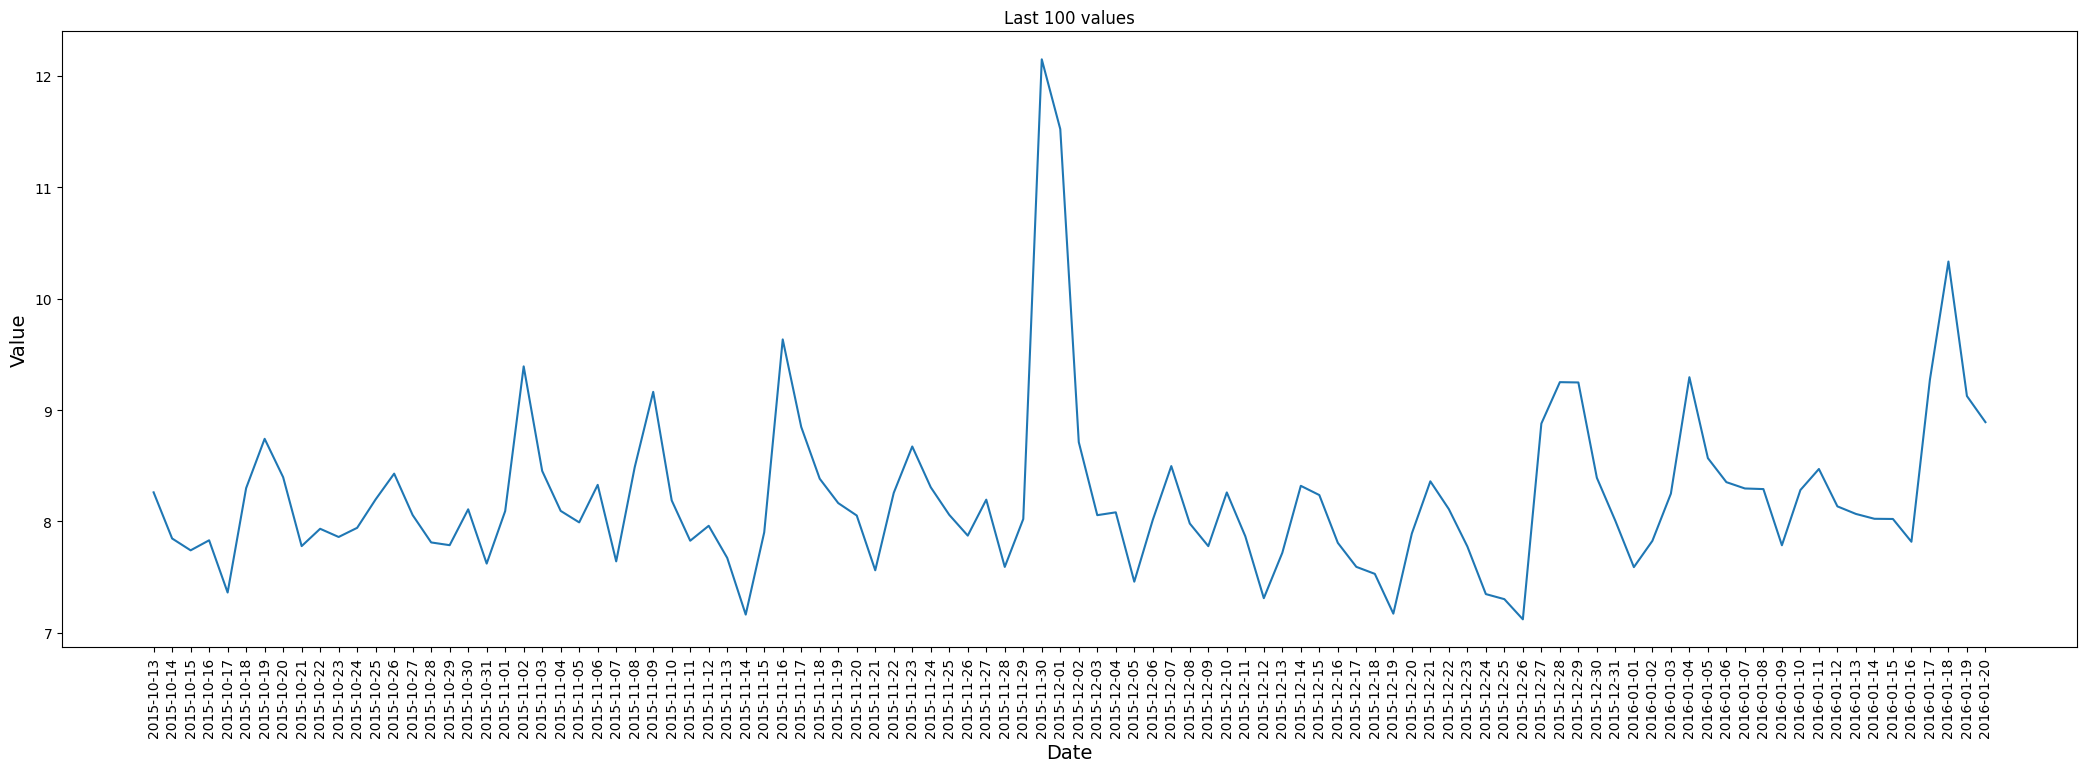

In [ ]:
# gráfica de tiempo
n = 100
plt.figure(figsize=(26,8))
plt.plot(df['ds'].tail(n), df['y'].tail(n))
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Last '+str(n)+' values')
plt.show()

**Autocorrelation plots**

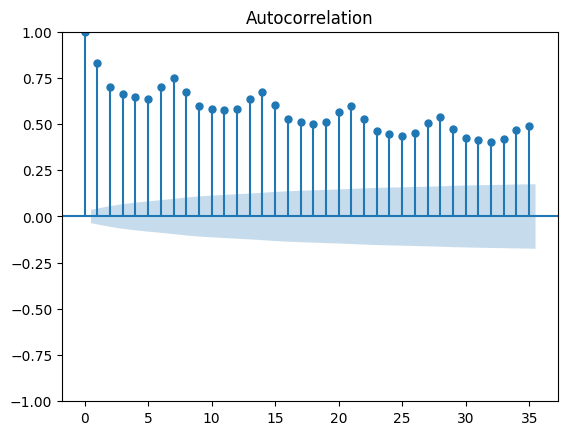

In [ ]:
# autocorrelation plot
plot_acf(df['y'])
plt.show()

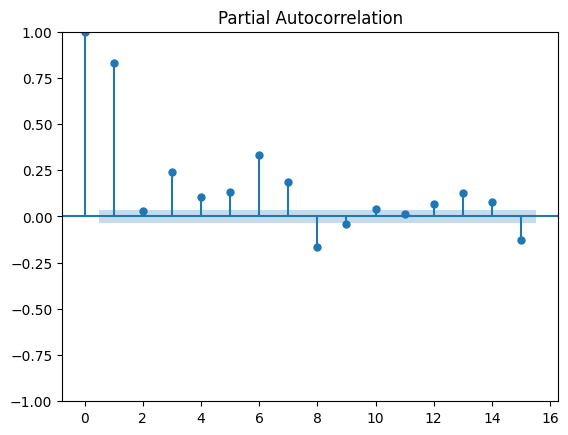

In [ ]:
# partial autocorrelation plot
plot_pacf(df['y'], lags=15)
plt.show()

**Stationarity Test (Dickey-Fuller)**

In [ ]:
for lag in range(1,10):
  adf, pval, usedlag, nobs, cval, icbest = adfuller(df['y'], maxlag=lag, autolag='AIC')
  print('Test Dicker-Fuller for {} lag: {} (pval: {})'.format(usedlag, round(adf,4), round(pval,4)))

Valor del Test de Dicker-Fuller para 1 lag: -15.1382 (pval: 0.0)
Valor del Test de Dicker-Fuller para 2 lag: -11.359 (pval: 0.0)
Valor del Test de Dicker-Fuller para 3 lag: -9.9789 (pval: 0.0)
Valor del Test de Dicker-Fuller para 4 lag: -8.5702 (pval: 0.0)
Valor del Test de Dicker-Fuller para 5 lag: -5.9387 (pval: 0.0)
Valor del Test de Dicker-Fuller para 6 lag: -4.8665 (pval: 0.0)
Valor del Test de Dicker-Fuller para 7 lag: -5.738 (pval: 0.0)
Valor del Test de Dicker-Fuller para 8 lag: -5.943 (pval: 0.0)
Valor del Test de Dicker-Fuller para 9 lag: -5.682 (pval: 0.0)


## Modeling

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1w1z67jy/a0rs0bm4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1w1z67jy/u8ki1hzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5588', 'data', 'file=/tmp/tmp1w1z67jy/a0rs0bm4.json', 'init=/tmp/tmp1w1z67jy/u8ki1hzv.json', 'output', 'file=/tmp/tmp1w1z67jy/prophet_modelp0iq4hvl/prophet_model-20240420163038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:30:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:30:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


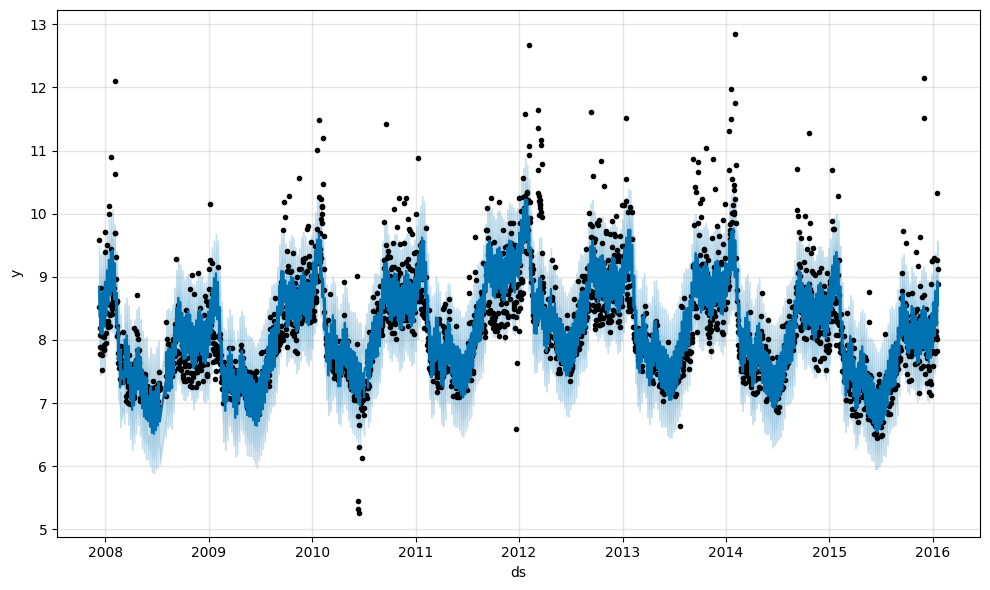

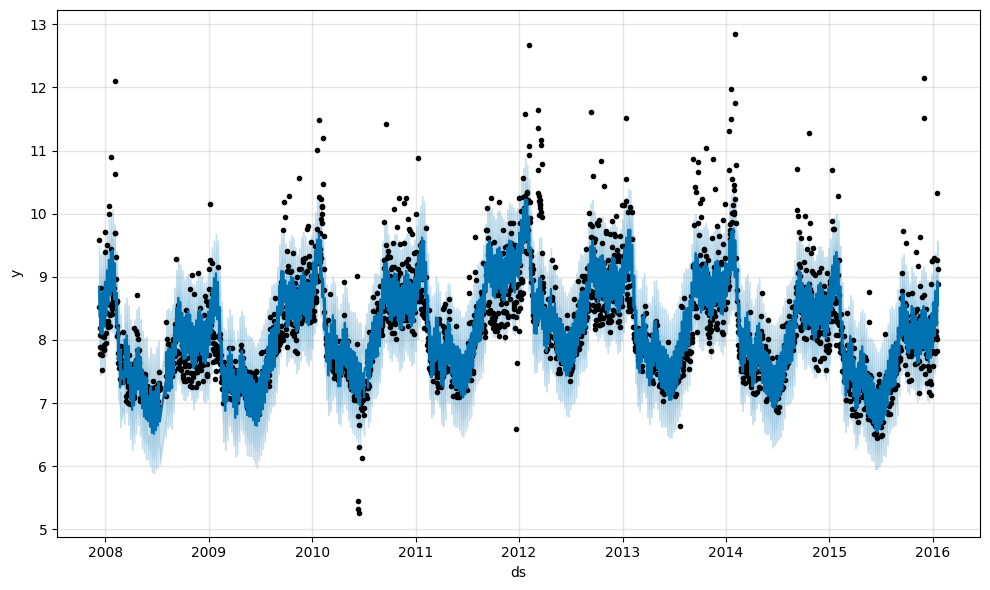

In [ ]:
# instantiate model
mod = Prophet()
mod.fit(df)

# get historical predictions
predictions = mod.predict(df)
mod.plot(predictions)

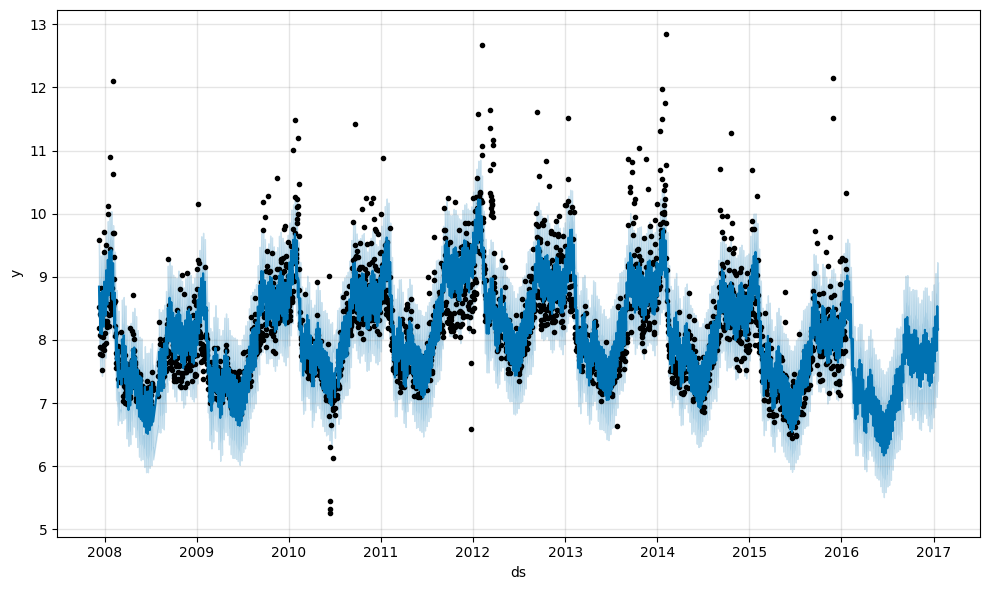

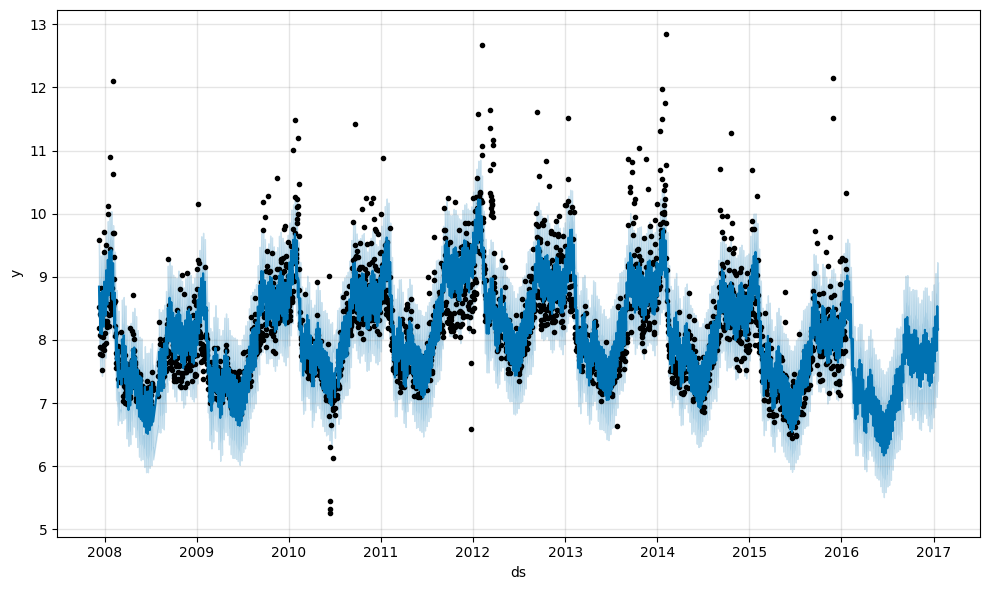

In [ ]:
# get forecast
future = mod.make_future_dataframe(periods=365)
forecast = mod.predict(future)
mod.plot(forecast)

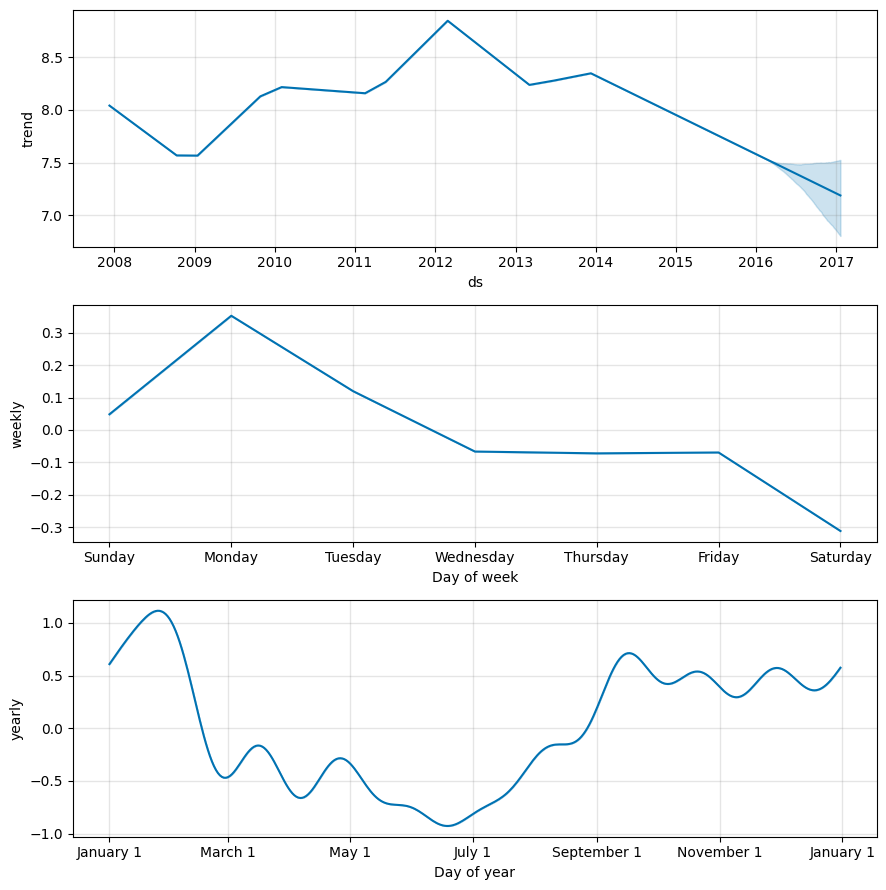

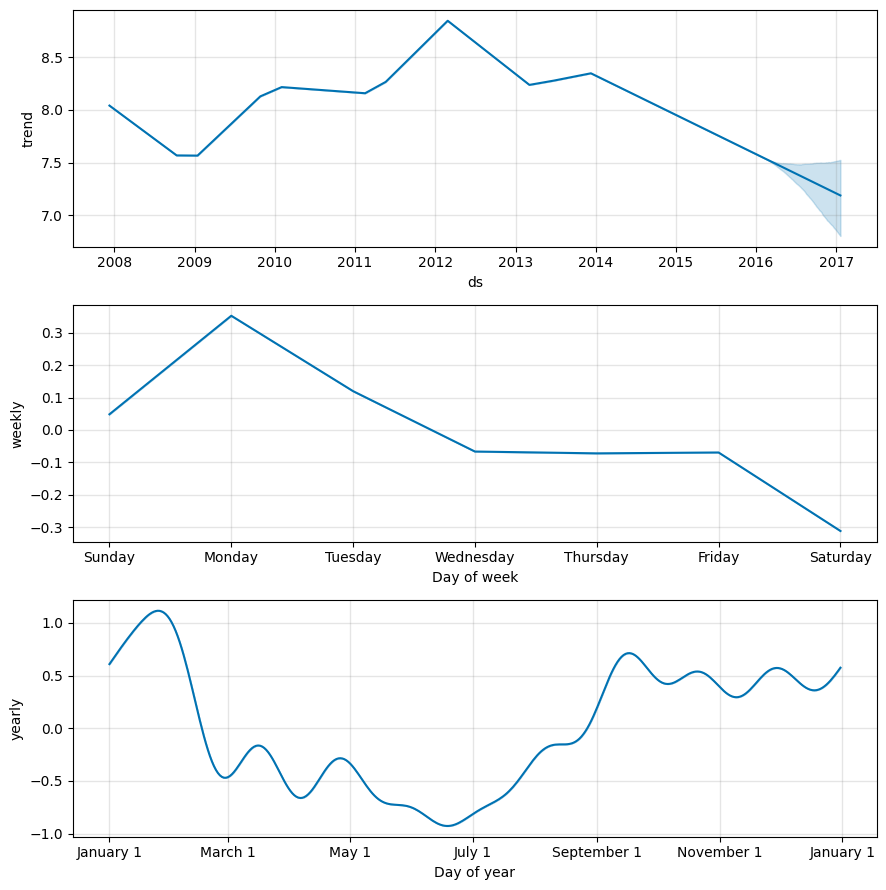

In [ ]:
# see forecast components
mod.plot_components(forecast)

**Generalized model (classic training-test split)**

In [ ]:
def train_test_split(df, per):
    df = df.sort_values('ds', ascending=True)
    m2 = round(df.shape[0]*per)
    m1 = df.shape[0] - m2
    train, test = df.head(m1), df.tail(m2)
    return train, test

df_train, df_test = train_test_split(df, 0.30)

**Model hyperparameters**

_growth_
Type of growth of the trend. It can be linear or logistic.

_changepoints_
Points in your data where there are sudden and abrupt changes in the trend. You can supply the points in a dataframe (not recommended).

_holidays_
Periods of time where the days have the same sort of effect each year. You can supply the points in a dataframe.

_changepoint_prior_scale_
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using this parameter.

_seasonality_prior_scale_
Adjusts the extent to which the seasonality model will fit the data.

_holidays_prior_scale_
If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using this parameter.

_add_seasonality_
Add custom seasonality for model. Parameters are: name (e.g. 'weekly', 'monthly'); period (integer, same scale); fourier order of seasonality (e.g. by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality)

In [ ]:
def create_model(growth='linear', seasonality_mode='additive', changepoint_prior_scale=0.05, seasonality_prior_scale=0.05, holidays=None, holidays_prior_scale=0.05):
    if holidays != None:
        model = Prophet(growth=growth,
                   holidays=holidays,
                   seasonality_mode=seasonality_mode,
                   changepoint_prior_scale=changepoint_prior_scale,
                   seasonality_prior_scale=seasonality_prior_scale,
                   holidays_prior_scale=holidays_prior_scale,
                   daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False
                   )
    else:
        model = Prophet(growth=growth,
                   seasonality_mode=seasonality_mode,
                   changepoint_prior_scale=changepoint_prior_scale,
                   seasonality_prior_scale=seasonality_prior_scale,
                   holidays_prior_scale=holidays_prior_scale,
                   daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False
                   )

    return model

def add_seasonality(model, name, period, fourier_order):
    model.add_seasonality(name=name,
                        period=period,
                        fourier_order=fourier_order)
    return model

mod1 = create_model()
mod1.fit(df_train)

Validation Metrics (Classical
MAE: 1.41 | MSE: 2.75 | MAPE: 0.17


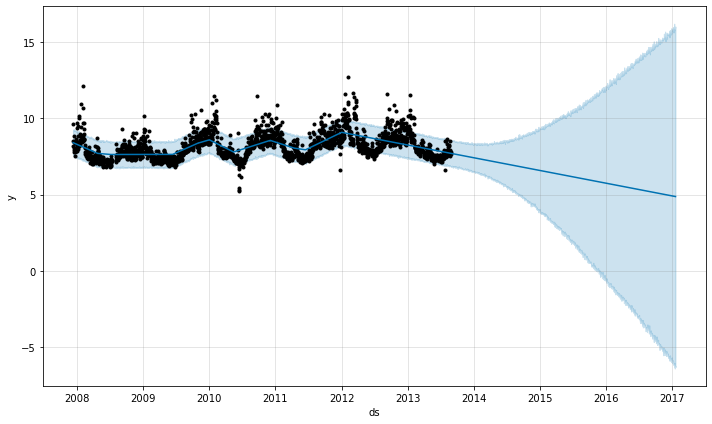

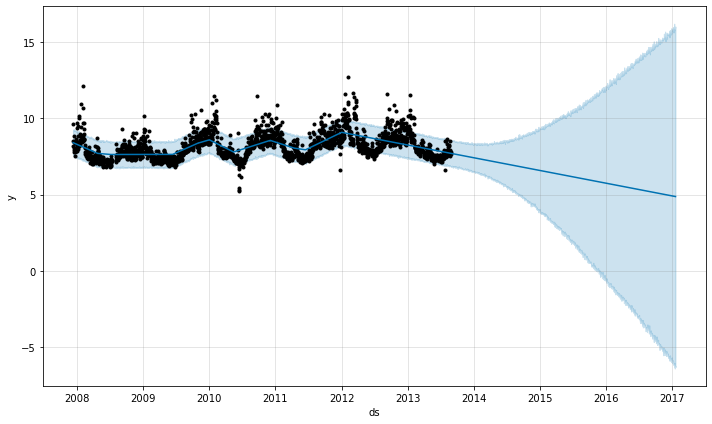

In [ ]:
val_obs = df_test['y']
val_preds = mod1.predict(df_test)['yhat']
print('Validation Metrics (Classical')
print('MAE: {} | MSE: {} | MAPE: {}'.format(round(MAE(val_obs, val_preds),2), round(MSE(val_obs, val_preds),2), round(MAPE(val_obs, val_preds),2)))

future1 = pd.concat([df_train[['ds']], df_test[['ds']]])
forecast1 = mod1.predict(future)
mod1.plot(forecast1)

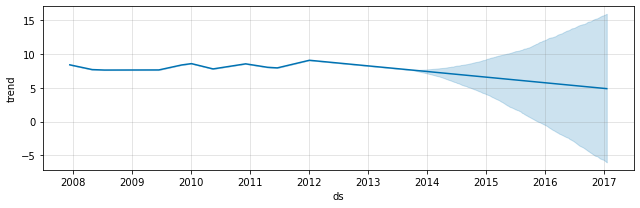

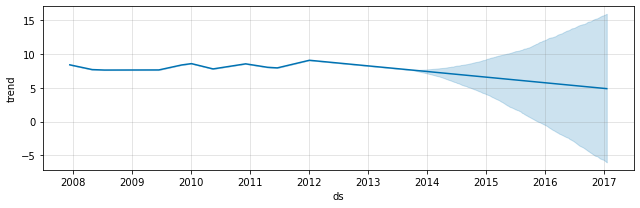

In [ ]:
mod1.plot_components(forecast1)

**Generalized model (Prophet cross-validation)**

In [ ]:
def create_model(growth='linear', seasonality_mode='additive', changepoint_prior_scale=0.05, seasonality_prior_scale=0.05, holidays=None, holidays_prior_scale=0.05):
    if holidays != None:
        model = Prophet(growth=growth,
                   holidays=holidays,
                   seasonality_mode=seasonality_mode,
                   changepoint_prior_scale=changepoint_prior_scale,
                   seasonality_prior_scale=seasonality_prior_scale,
                   holidays_prior_scale=holidays_prior_scale,
                   daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False
                   )
    else:
        model = Prophet(growth=growth,
                   seasonality_mode=seasonality_mode,
                   changepoint_prior_scale=changepoint_prior_scale,
                   seasonality_prior_scale=seasonality_prior_scale,
                   holidays_prior_scale=holidays_prior_scale,
                   daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False
                   )

    return model

def add_seasonality(model, name, period, fourier_order):
    model.add_seasonality(name=name,
                        period=period,
                        fourier_order=fourier_order)
    return model

mod2 = create_model()
mod2.fit(df)

**cross-validation**

This cross validation procedure can be done automatically for a range of historical cutoffs.

_initial_
Amount of training data to be used in the first cutoff.

_period_
Make predictions every period specified.

_horizon_
Assess prediction performance on a specified horizon of time.

_units_
Time units of data.

In [ ]:
# perform cross  validation
df_cv = cross_validation(mod2, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.48s/it]


In [ ]:
# get cross-validation performance metrics
df_p = performance_metrics(df_cv)
df_p.head(10)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,1.552172,1.245862,0.987209,0.117979,0.102891,0.116766,0.490635
1,38 days,1.598523,1.264327,1.002815,0.119938,0.105867,0.118692,0.485610
2,39 days,1.650537,1.284732,1.021931,0.122269,0.107053,0.121002,0.479214
3,40 days,1.680620,1.296387,1.034674,0.123976,0.107428,0.122616,0.475560
4,41 days,1.706957,1.306506,1.045061,0.125370,0.109662,0.123942,0.474189
5,42 days,1.735412,1.317350,1.057998,0.126975,0.109692,0.125549,0.473047
6,43 days,1.762319,1.327524,1.072139,0.128623,0.112295,0.127232,0.465509
7,44 days,1.789217,1.337616,1.085154,0.130213,0.113155,0.128786,0.459799
8,45 days,1.789963,1.337895,1.093467,0.131582,0.113775,0.129961,0.455459
9,46 days,1.817303,1.348074,1.106366,0.133204,0.117100,0.131553,0.446551


MAPE


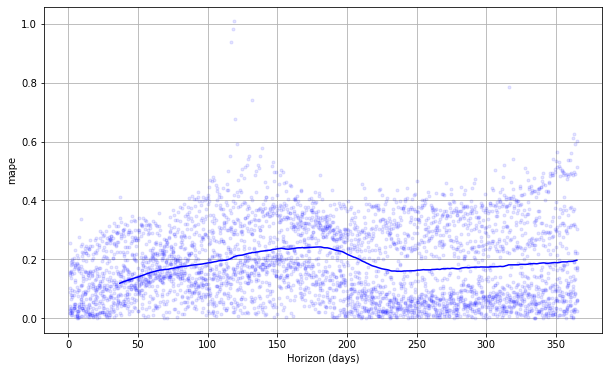

In [ ]:
# plot validation metric (MAPE)
print('MAPE')
fig = plot_cross_validation_metric(df_cv, metric='mape')

MSE


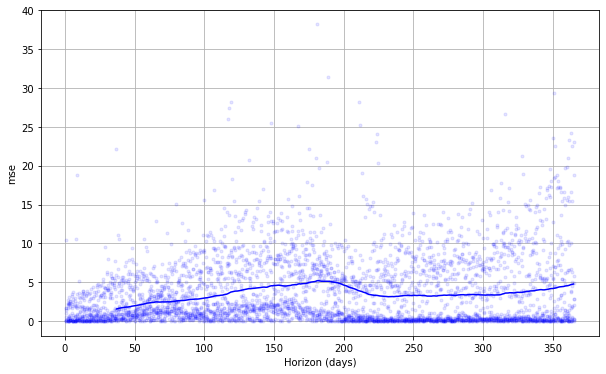

In [ ]:
# plot validation metric (MSE)
print('MSE')
fig = plot_cross_validation_metric(df_cv, metric='mse')